# LightGBM Train

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/RecSys2024/
base_path = '/content/drive/MyDrive/RecSys2024/'

Mounted at /content/drive
input  Recsys2024_lgb_train.ipynb


In [8]:
import pandas as pd
import polars as pl
import numpy as np
import pickle

In [64]:
DEBUG_MODE = True

# Preprocessing

In [65]:
if DEBUG_MODE:
  input_path = base_path + 'input/ebnerd_small/'
else:
  input_path = base_path + 'input/ebnerd_large/'

In [66]:
!ls {input_path}

articles.parquet  train  validation


In [67]:
article = pl.read_parquet(input_path + '/articles.parquet')

train_behavior = pl.read_parquet(input_path + 'train/behaviors.parquet')
train_history = pl.read_parquet(input_path + 'train/history.parquet')
valid_behavior = pl.read_parquet(input_path + 'validation/behaviors.parquet')
valid_history = pl.read_parquet(input_path +  'validation/history.parquet')

In [68]:
print(train_behavior.shape)
train_behavior.head()

(232887, 17)


impression_id,article_id,impression_time,read_time,scroll_percentage,device_type,article_ids_inview,article_ids_clicked,user_id,is_sso_user,gender,postcode,age,is_subscriber,session_id,next_read_time,next_scroll_percentage
u32,i32,datetime[μs],f32,f32,i8,list[i32],list[i32],u32,bool,i8,i8,i8,bool,u32,f32,f32
149474,null,2023-05-24 07:47:53,13.0,null,2,"[9778623, 9778682, … 9778728]",[9778657],139836,false,null,null,null,false,759,7.0,22.0
150528,null,2023-05-24 07:33:25,25.0,null,2,"[9778718, 9778728, … 9778682]",[9778623],143471,false,null,null,null,false,1240,287.0,100.0
153068,9778682,2023-05-24 07:09:04,78.0,100.0,1,"[9778657, 9778669, … 9778682]",[9778669],151570,false,null,null,null,false,1976,45.0,100.0
153070,9777492,2023-05-24 07:13:14,26.0,100.0,1,"[9020783, 9778444, … 9778628]",[9778628],151570,false,null,null,null,false,1976,4.0,18.0
153071,9778623,2023-05-24 07:11:08,125.0,100.0,1,"[9777492, 9774568, … 9775990]",[9777492],151570,false,null,null,null,false,1976,26.0,100.0


In [70]:
print(train_behavior.select(pl.col("impression_time")).min())
print(train_behavior.select(pl.col("impression_time")).max())

shape: (1, 1)
┌─────────────────────┐
│ impression_time     │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2023-05-18 07:00:01 │
└─────────────────────┘
shape: (1, 1)
┌─────────────────────┐
│ impression_time     │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2023-05-25 06:59:58 │
└─────────────────────┘


In [71]:
print(valid_behavior.shape)
valid_behavior.head()

(244647, 17)


impression_id,article_id,impression_time,read_time,scroll_percentage,device_type,article_ids_inview,article_ids_clicked,user_id,is_sso_user,gender,postcode,age,is_subscriber,session_id,next_read_time,next_scroll_percentage
u32,i32,datetime[μs],f32,f32,i8,list[i32],list[i32],u32,bool,i8,i8,i8,bool,u32,f32,f32
96791,null,2023-05-28 04:21:24,9.0,null,2,"[9783865, 9784591, … 9784710]",[9784696],22548,false,null,null,null,false,142,72.0,100.0
96798,null,2023-05-28 04:31:48,46.0,null,2,"[9782884, 9783865, … 9784648]",[9784281],22548,false,null,null,null,false,143,16.0,28.0
96801,null,2023-05-28 04:30:17,14.0,null,2,"[9784648, 7184889, … 9781983]",[9784444],22548,false,null,null,null,false,143,12.0,24.0
96808,null,2023-05-28 04:27:19,22.0,null,2,"[9784607, 9695098, … 9781983]",[9781983],22548,false,null,null,null,false,142,125.0,80.0
96810,null,2023-05-28 04:29:47,23.0,null,2,"[9781983, 7184889, … 9781520]",[9784642],22548,false,null,null,null,false,142,null,null


In [72]:
print(valid_behavior.select(pl.col("impression_time")).min())
print(valid_behavior.select(pl.col("impression_time")).max())

shape: (1, 1)
┌─────────────────────┐
│ impression_time     │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2023-05-25 07:00:02 │
└─────────────────────┘
shape: (1, 1)
┌─────────────────────┐
│ impression_time     │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2023-06-01 06:59:59 │
└─────────────────────┘


In [73]:
print(train_history.shape)
train_history.head()

(15143, 5)


user_id,impression_time_fixed,scroll_percentage_fixed,article_id_fixed,read_time_fixed
u32,list[datetime[μs]],list[f32],list[i32],list[f32]
13538,"[2023-04-27 10:17:43, 2023-04-27 10:18:01, … 2023-05-17 20:36:34]","[100.0, 35.0, … 100.0]","[9738663, 9738569, … 9769366]","[17.0, 12.0, … 16.0]"
14241,"[2023-04-27 09:40:18, 2023-04-27 09:40:33, … 2023-05-17 17:08:41]","[100.0, 46.0, … 100.0]","[9738557, 9738528, … 9767852]","[8.0, 9.0, … 12.0]"
20396,"[2023-04-27 12:30:44, 2023-04-27 12:31:34, … 2023-05-17 10:59:44]","[100.0, 59.0, … 13.0]","[9738760, 9738355, … 9769679]","[49.0, 34.0, … 4.0]"
34912,"[2023-04-29 07:12:49, 2023-04-29 13:01:18, … 2023-05-18 05:06:40]","[100.0, 35.0, … 27.0]","[9741802, 9741804, … 9770882]","[153.0, 7.0, … 5.0]"
37953,"[2023-04-27 19:17:10, 2023-04-27 19:17:27, … 2023-05-17 21:29:22]","[14.0, 28.0, … 18.0]","[9739205, 9739202, … 9769306]","[4.0, 16.0, … 6.0]"


In [74]:
print(valid_history.shape)
valid_history.head()

(15342, 5)


user_id,impression_time_fixed,scroll_percentage_fixed,article_id_fixed,read_time_fixed
u32,list[datetime[μs]],list[f32],list[i32],list[f32]
14241,"[2023-05-04 12:42:38, 2023-05-04 12:43:04, … 2023-05-24 13:58:04]","[100.0, 77.0, … 100.0]","[9578072, 9749349, … 9779289]","[20.0, 16.0, … 1.0]"
20396,"[2023-05-04 10:09:26, 2023-05-04 10:47:17, … 2023-05-24 20:51:06]","[null, 100.0, … 11.0]","[9748482, 9748916, … 9779489]","[0.0, 69.0, … 8.0]"
37953,"[2023-05-04 20:51:41, 2023-05-04 20:51:55, … 2023-05-24 21:10:46]","[25.0, 13.0, … 97.0]","[9750397, 9749916, … 9778902]","[5.0, 5.0, … 13.0]"
38910,"[2023-05-04 13:41:54, 2023-05-04 13:41:57, … 2023-05-25 05:43:36]","[null, 23.0, … 100.0]","[9745491, 9749729, … 9779577]","[2.0, 2.0, … 71.0]"
39221,"[2023-05-06 03:54:52, 2023-05-06 03:56:00, … 2023-05-23 23:14:07]","[100.0, 100.0, … 24.0]","[9749034, 9751385, … 9778168]","[67.0, 82.0, … 3.0]"


In [31]:
print(article.shape)
article.head()

(125541, 21)


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str
3000022,"""Hanks beskyldt…","""Tom Hanks har …",2023-06-29 06:20:32,false,"""Tom Hanks skul…",2006-09-20 09:24:18,[3518381],"""article_defaul…","""https://ekstra…","[""David Gardner""]","[""PER""]","[""Kriminalitet"", ""Kendt"", … ""Litteratur""]",414,[432],"""underholdning""",null,null,null,0.9911,"""Negative"""
3000063,"""Bostrups aske …","""Studieværten b…",2023-06-29 06:20:32,false,"""Strålende sens…",2006-09-24 07:45:30,"[3170935, 3170939]","""article_defaul…","""https://ekstra…",[],[],"[""Kendt"", ""Underholdning"", … ""Personlig begivenhed""]",118,[133],"""nyheder""",null,null,null,0.5155,"""Neutral"""
3000613,"""Jesper Olsen r…","""Den tidligere …",2023-06-29 06:20:33,false,"""Jesper Olsen, …",2006-05-09 11:29:00,[3164998],"""article_defaul…","""https://ekstra…","[""Frankrig"", ""Jesper Olsen"", … ""Jesper Olsen""]","[""LOC"", ""PER"", … ""PER""]","[""Kendt"", ""Sport"", … ""Sygdom og behandling""]",142,"[196, 271]","""sport""",null,null,null,0.9876,"""Negative"""
3000700,"""Madonna topløs…","""47-årige Madon…",2023-06-29 06:20:33,false,"""Skal du have s…",2006-05-04 11:03:12,[3172046],"""article_defaul…","""https://ekstra…",[],[],"[""Kendt"", ""Livsstil"", ""Underholdning""]",414,[432],"""underholdning""",null,null,null,0.8786,"""Neutral"""
3000840,"""Otto Brandenbu…","""Sangeren og sk…",2023-06-29 06:20:33,false,"""'Og lidt for S…",2007-03-01 18:34:00,[3914446],"""article_defaul…","""https://ekstra…",[],[],"[""Kendt"", ""Underholdning"", … ""Musik og lyd""]",118,[133],"""nyheder""",null,null,null,0.9468,"""Negative"""


In [75]:
train_history.join(valid_history, on="user_id", how="inner")

user_id,impression_time_fixed,scroll_percentage_fixed,article_id_fixed,read_time_fixed,impression_time_fixed_right,scroll_percentage_fixed_right,article_id_fixed_right,read_time_fixed_right
u32,list[datetime[μs]],list[f32],list[i32],list[f32],list[datetime[μs]],list[f32],list[i32],list[f32]
14241,"[2023-04-27 09:40:18, 2023-04-27 09:40:33, … 2023-05-17 17:08:41]","[100.0, 46.0, … 100.0]","[9738557, 9738528, … 9767852]","[8.0, 9.0, … 12.0]","[2023-05-04 12:42:38, 2023-05-04 12:43:04, … 2023-05-24 13:58:04]","[100.0, 77.0, … 100.0]","[9578072, 9749349, … 9779289]","[20.0, 16.0, … 1.0]"
20396,"[2023-04-27 12:30:44, 2023-04-27 12:31:34, … 2023-05-17 10:59:44]","[100.0, 59.0, … 13.0]","[9738760, 9738355, … 9769679]","[49.0, 34.0, … 4.0]","[2023-05-04 10:09:26, 2023-05-04 10:47:17, … 2023-05-24 20:51:06]","[null, 100.0, … 11.0]","[9748482, 9748916, … 9779489]","[0.0, 69.0, … 8.0]"
37953,"[2023-04-27 19:17:10, 2023-04-27 19:17:27, … 2023-05-17 21:29:22]","[14.0, 28.0, … 18.0]","[9739205, 9739202, … 9769306]","[4.0, 16.0, … 6.0]","[2023-05-04 20:51:41, 2023-05-04 20:51:55, … 2023-05-24 21:10:46]","[25.0, 13.0, … 97.0]","[9750397, 9749916, … 9778902]","[5.0, 5.0, … 13.0]"
38910,"[2023-04-27 08:23:57, 2023-04-27 08:25:38, … 2023-05-17 20:58:49]","[100.0, 25.0, … null]","[9737521, 9738292, … 9770741]","[99.0, 4.0, … 0.0]","[2023-05-04 13:41:54, 2023-05-04 13:41:57, … 2023-05-25 05:43:36]","[null, 23.0, … 100.0]","[9745491, 9749729, … 9779577]","[2.0, 2.0, … 71.0]"
39221,"[2023-04-27 15:13:28, 2023-04-27 15:14:20, … 2023-05-16 20:34:37]","[100.0, 100.0, … 100.0]","[9738980, 9714273, … 9759345]","[51.0, 46.0, … 19.0]","[2023-05-06 03:54:52, 2023-05-06 03:56:00, … 2023-05-23 23:14:07]","[100.0, 100.0, … 24.0]","[9749034, 9751385, … 9778168]","[67.0, 82.0, … 3.0]"
44213,"[2023-04-27 08:11:23, 2023-04-27 08:12:23, … 2023-05-17 22:15:39]","[27.0, null, … 43.0]","[9738292, 9737556, … 9769575]","[17.0, 80.0, … 13.0]","[2023-05-04 14:04:54, 2023-05-04 18:29:57, … 2023-05-25 05:01:21]","[100.0, 100.0, … 48.0]","[9749729, 9750209, … 9780096]","[44.0, 203.0, … 14.0]"
48300,"[2023-05-09 08:21:55, 2023-05-09 08:22:50, … 2023-05-18 06:48:55]","[null, 20.0, … null]","[9754087, 9755696, … 9766140]","[55.0, 16.0, … 430.0]","[2023-05-09 08:21:55, 2023-05-09 08:22:50, … 2023-05-25 05:32:02]","[null, 20.0, … 100.0]","[9754087, 9755696, … 9780193]","[55.0, 16.0, … 8.0]"
52527,"[2023-04-27 11:43:02, 2023-04-27 11:43:41, … 2023-05-17 20:04:28]","[68.0, 93.0, … 62.0]","[9738777, 9738684, … 9770492]","[19.0, 38.0, … 0.0]","[2023-05-05 17:38:34, 2023-05-05 17:39:34, … 2023-05-23 04:30:09]","[100.0, 36.0, … 36.0]","[9751115, 9750990, … 9773392]","[49.0, 6.0, … 315.0]"
54469,"[2023-04-27 07:35:06, 2023-04-27 07:36:30, … 2023-05-17 20:05:15]","[41.0, 91.0, … 84.0]","[9738193, 9737535, … 9769981]","[4.0, 60.0, … 65.0]","[2023-05-04 10:29:18, 2023-05-04 10:29:37, … 2023-05-25 05:37:33]","[35.0, 19.0, … 65.0]","[9749278, 9747443, … 9779860]","[5.0, 30.0, … 21.0]"


# Test Data

In [35]:
test_path = base_path + 'input/ebnerd_testset/'

In [36]:
test_article = pl.read_parquet(test_path + '/articles.parquet')
test_behavior = pl.read_parquet(test_path + 'test/behaviors.parquet')
test_history = pl.read_parquet(test_path + 'test/history.parquet')

In [37]:
print(test_behavior.shape)
test_behavior.head()

(13536710, 14)


impression_id,impression_time,read_time,scroll_percentage,device_type,article_ids_inview,user_id,is_sso_user,gender,postcode,age,is_subscriber,session_id,is_beyond_accuracy
u32,datetime[μs],f32,f32,i8,list[i32],u32,bool,i8,i8,i8,bool,u32,bool
6451339,2023-06-05 15:02:49,8.0,null,2,"[9796527, 7851321, … 9492777]",35982,false,null,null,null,false,388,false
6451363,2023-06-05 15:03:56,20.0,null,2,"[9798532, 9791602, … 9798958]",36012,false,null,null,null,false,804,false
6451382,2023-06-05 15:25:53,9.0,null,2,"[9798498, 9793856, … 9798724]",36162,false,null,null,null,false,1528,false
6451383,2023-06-05 15:26:35,14.0,null,2,"[9797419, 9798829, … 9798805]",36162,false,null,null,null,false,1528,false
6451385,2023-06-05 15:26:14,8.0,null,2,"[9785014, 9798958, … 9486080]",36162,false,null,null,null,false,1528,false


In [63]:
print(test_behavior.select(pl.col("impression_time")).min())
print(test_behavior.select(pl.col("impression_time")).max())

shape: (1, 1)
┌─────────────────────┐
│ impression_time     │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2023-06-01 07:00:00 │
└─────────────────────┘
shape: (1, 1)
┌─────────────────────┐
│ impression_time     │
│ ---                 │
│ datetime[μs]        │
╞═════════════════════╡
│ 2023-06-08 06:59:59 │
└─────────────────────┘


In [38]:
print(test_history.shape)
test_history.head()

(807677, 5)


user_id,impression_time_fixed,scroll_percentage_fixed,article_id_fixed,read_time_fixed
u32,list[datetime[μs]],list[f32],list[i32],list[f32]
40107,"[2023-05-11 07:51:01, 2023-05-13 20:09:06, … 2023-06-01 05:38:18]","[15.0, 100.0, … 7.0]","[9676294, 9763942, … 9776147]","[25.0, 39.0, … 43.0]"
40254,"[2023-05-11 08:40:26, 2023-05-11 08:41:18, … 2023-06-01 06:18:54]","[100.0, 72.0, … null]","[9759284, 9759389, … 9789473]","[49.0, 16.0, … 0.0]"
40926,"[2023-05-11 10:48:39, 2023-05-11 10:58:37, … 2023-06-01 05:43:38]","[98.0, 45.0, … 65.0]","[9759355, 9759707, … 9789896]","[595.0, 2.0, … 20.0]"
40963,"[2023-05-11 17:36:20, 2023-05-11 17:38:00, … 2023-05-31 22:54:10]","[100.0, 40.0, … 29.0]","[9759929, 9757526, … 9789475]","[46.0, 18.0, … 20.0]"
41474,"[2023-05-14 05:59:04, 2023-05-14 06:02:10, … 2023-05-25 08:17:28]","[null, 100.0, … 82.0]","[9762373, 9761561, … 9780406]","[176.0, 274.0, … 10.0]"


In [39]:
print(test_article.shape)
test_article.head()

(125541, 21)


article_id,title,subtitle,last_modified_time,premium,body,published_time,image_ids,article_type,url,ner_clusters,entity_groups,topics,category,subcategory,category_str,total_inviews,total_pageviews,total_read_time,sentiment_score,sentiment_label
i32,str,str,datetime[μs],bool,str,datetime[μs],list[i64],str,str,list[str],list[str],list[str],i16,list[i16],str,i32,i32,f32,f32,str
3000022,"""Hanks beskyldt…","""Tom Hanks har …",2023-06-29 06:20:32,false,"""Tom Hanks skul…",2006-09-20 09:24:18,[3518381],"""article_defaul…","""https://ekstra…","[""David Gardner""]","[""PER""]","[""Kriminalitet"", ""Kendt"", … ""Litteratur""]",414,[432],"""underholdning""",null,null,null,0.9911,"""Negative"""
3000063,"""Bostrups aske …","""Studieværten b…",2023-06-29 06:20:32,false,"""Strålende sens…",2006-09-24 07:45:30,"[3170935, 3170939]","""article_defaul…","""https://ekstra…",[],[],"[""Kendt"", ""Underholdning"", … ""Personlig begivenhed""]",118,[133],"""nyheder""",null,null,null,0.5155,"""Neutral"""
3000613,"""Jesper Olsen r…","""Den tidligere …",2023-06-29 06:20:33,false,"""Jesper Olsen, …",2006-05-09 11:29:00,[3164998],"""article_defaul…","""https://ekstra…","[""Frankrig"", ""Jesper Olsen"", … ""Jesper Olsen""]","[""LOC"", ""PER"", … ""PER""]","[""Kendt"", ""Sport"", … ""Sygdom og behandling""]",142,"[196, 271]","""sport""",null,null,null,0.9876,"""Negative"""
3000700,"""Madonna topløs…","""47-årige Madon…",2023-06-29 06:20:33,false,"""Skal du have s…",2006-05-04 11:03:12,[3172046],"""article_defaul…","""https://ekstra…",[],[],"[""Kendt"", ""Livsstil"", ""Underholdning""]",414,[432],"""underholdning""",null,null,null,0.8786,"""Neutral"""
3000840,"""Otto Brandenbu…","""Sangeren og sk…",2023-06-29 06:20:33,false,"""'Og lidt for S…",2007-03-01 18:34:00,[3914446],"""article_defaul…","""https://ekstra…",[],[],"[""Kendt"", ""Underholdning"", … ""Musik og lyd""]",118,[133],"""nyheder""",null,null,null,0.9468,"""Negative"""


In [ ]:
# ====================================================
# Library
# ====================================================
import gc
import warnings
warnings.filterwarnings('ignore')
import scipy as sp
import numpy as np
import pandas as pd
import glob
import joblib

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
import itertools
from sklearn.model_selection import KFold, train_test_split
if OPTUNA_FLAG:
    import optuna.integration.lightgbm as lgb
else:
    import lightgbm as lgb

In [ ]:
IGNORE_COL_TARGET = ['is_clicked', 'is_installed']
# f_7:all val=27941
# importance=0: f_26, f_27, f_28, f_29, f_77
#IGNORE_COL = ['f_0', 'f_1', 'f_7', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28', 'f_29', 'f_77']
IGNORE_COL = ['f_0', 'f_1', 'f_7']
#IGNORE_COL_FINAL = ['f_0', 'f_1', 'f_7', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28', 'f_29', 'f_77'] # remove after diff feature generations
IGNORE_COL_FINAL = ['f_0', 'f_1', 'f_7']


cat_features = [f'f_{i}' for i in range(2,33) if f'f_{i}' not in IGNORE_COL_FINAL]
bin_features = [f'f_{i}' for i in range(33,42) if f'f_{i}' not in IGNORE_COL_FINAL]
# num featuresだけどuniqueな値が少ないやつ
#num_small_features = ['f_44', 'f_45', 'f_46', 'f_47', 'f_48', 'f_49', 'f_50', 'f_71', 'f_72', 'f_73', 'f_74', 'f_76', 'f_78', 'f_79']
cat_features_origin = cat_features
cat_features = cat_features + bin_features
#cat_features = cat_features + bin_features + num_small_features

In [ ]:
def reduce_memory(df):
  df[f'f_0'] = df[f'f_0'].astype('int32')
  # Date and categorical feature
  for i in range(1, 33):
    df[f'f_{i}'] = df[f'f_{i}'].fillna(-1).astype('int16')
  # Binary feature
  for i in range(33, 42):
    df[f'f_{i}'] = df[f'f_{i}'].astype('bool')
  return df


def add_interactive_features(df):
    # ratio features
    ratio_feature_list = [
    ('f_42', 'f_61', 'f_62', 'f_63'),
    ('f_43', 'f_66', 'f_70'),
    ('f_48', 'f_49', 'f_50'),
    ('f_52', 'f_53', 'f_54'),
    ('f_55', 'f_56', 'f_57'),
    ('f_64', 'f_65'),
    ('f_68', 'f_69'),
    ('f_71', 'f_72', 'f_73'),
    ('f_74', 'f_75', 'f_76'),
    ('f_78', 'f_79')
    ]
    mean_df = df.mean()
    for l in ratio_feature_list:
        df = generate_ratio_feature(l, mean_df, df)

    # mult features
    mult_feature_list = [
    ('f_51', 'f_43'),
    ('f_51', 'f_66'),
    ('f_51', 'f_70'),
    ]
    for l in mult_feature_list:
        df = generate_mult_feature(l, df)
    return df


# if mean col1<col2, then genereate col1/col2 as feature
def generate_ratio_feature(col_list, mean_df, df):
    small_val = 10**(-6)
    for i, col1 in enumerate(col_list):
        for j, col2 in enumerate(col_list):
            if j <= i:
                continue
            if mean_df[col1] < mean_df[col2]:
                df[f'ratio_{col1}/{col2}'] = (df[col1] / (df[col2] + small_val)).astype('float32')
            else:
                df[f'ratio_{col2}/{col1}'] = (df[col2] / (df[col1] + small_val)).astype('float32')
    return df


def generate_mult_feature(col_list, df):
    col1, col2 = col_list[0], col_list[1]
    df[f'mult_{col1}_{col2}'] = (df[col1] * df[col2]).astype('float32')
    return df

'''
# all day frequency encoding
def add_freq_encoding(col_list, train, test):

    train_tar =  train[IGNORE_COL_TARGET]
    train = train.drop(IGNORE_COL_TARGET, axis=1)
    df = pd.concat([train, test], axis=0)

    ignore = {'f_23','f_24','f_25','f_26','f_27','f_28','f_29','f_33','f_39'}
    for col in col_list:
        print('col=', col)
        if col in ignore:
            print('skip.....')
            continue
        df[f'{col}_count'] = df[col].map(df[col].value_counts()).astype('int32')
    train =  pd.concat([df.query('f_1<67'), train_tar], axis=1)
    test = df.query('f_1 == 67')
    return train, test
'''

In [ ]:
dfs = []
for i, chunk_file in enumerate(glob.glob('/content/drive/MyDrive/RecSys2023/sharechat_recsys2023_data/train/*')):
  if i%5 == 0:
    print('read training file', i)
  chunk = pd.read_csv(chunk_file, sep='\t')
  dfs.append(chunk)
train = pd.concat(dfs).reset_index(drop=True)
train = reduce_memory(train)
train['is_clicked'] = train['is_clicked'].astype('bool')
train['is_installed'] = train['is_installed'].astype('bool')

read training file 0
read training file 5
read training file 10
read training file 15
read training file 20
read training file 25


In [ ]:
train = add_interactive_features(train)

In [ ]:
print(train.shape)
train.head()

(3485852, 112)


,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,f_60,f_61,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,is_clicked,is_installed,ratio_f_61/f_42,ratio_f_62/f_42,ratio_f_63/f_42,ratio_f_61/f_62,ratio_f_61/f_63,ratio_f_62/f_63,ratio_f_66/f_43,ratio_f_70/f_43,ratio_f_70/f_66,ratio_f_49/f_48,ratio_f_48/f_50,ratio_f_49/f_50,ratio_f_53/f_52,ratio_f_52/f_54,ratio_f_53/f_54,ratio_f_56/f_55,ratio_f_55/f_57,ratio_f_56/f_57,ratio_f_65/f_64,ratio_f_68/f_69,ratio_f_71/f_72,ratio_f_71/f_73,ratio_f_73/f_72,ratio_f_74/f_75,ratio_f_74/f_76,ratio_f_76/f_75,ratio_f_79/f_78,mult_f_51_f_43,mult_f_51_f_66,mult_f_51_f_70
0,2541162,51,6581,22294,5491,25604,14597,27941,18800,31372,22970,32266,11402,17705,26082,19819,14709,28694,5774,25952,21553,0,0,0,0,0,0,0,0,0,-1,-1,3,True,True,True,True,True,True,False,False,False,26.146438,1.400127,0.0,0.0,0.0,0.0,0.0,0.0,0.571121,2.510696,0.038564,0.000000,0.617025,0.809845,0.077128,2.545229,0.803333,3.397252,0.0,0.000000,1.680896,2.841769,69350014.0,1462.240096,1.599715,7.851265,0.000000,0.000000,2.828680,1.142243,3.997850,1.713364,0.115692,1.156922,0.269948,0.0,0.0,0.0,False,False,0.000000,0.064288,0.108687,0.000000,0.00000,0.591496,1.142549,2.020301,1.768239,0.0,0.0,0.0,0.000000,0.06250,0.00000,0.095238,0.318182,0.030303,0.000021,0.000000,0.285714,0.666666,0.428571,0.100000,0.428570,0.233333,0.0,3.515294,4.016398,7.101955
1,2541260,49,20095,563,22861,15908,22651,27941,21218,869,19343,12213,30670,4230,20899,13481,25546,3249,12020,26758,4222,4625,0,0,0,0,0,0,0,0,-1,-1,3,False,False,False,True,True,True,False,False,False,7.982762,0.001049,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,30.726136,0.000000,0.000000,0.000000,0.308513,0.000000,0.385641,1.518634,3.205653,0.0,0.000000,0.000000,0.000000,126347712.0,1639.124417,0.000873,8.157427,1.089364,1.646756,0.000000,0.000000,0.000000,0.000000,0.115692,1.156922,0.269948,0.0,0.0,0.0,False,False,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.830965,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.799998,0.000000,0.000013,0.661521,0.000000,0.000000,0.000000,0.100000,0.428570,0.233333,0.0,0.032238,0.026814,0.000000
2,2541318,51,20095,563,22861,25604,22651,27941,21218,31372,22970,11407,17133,18614,26082,32590,25546,29718,21865,26758,4222,4625,0,0,0,0,0,0,0,0,-1,-1,3,False,False,False,True,True,True,False,False,False,5.784610,0.000187,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,25.668477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.511121,2.413887,0.0,0.295702,0.387899,0.000000,192447264.0,1808.083683,0.000156,8.269833,1.106260,2.220819,0.000000,0.000000,0.000000,0.000000,0.038564,1.156922,0.269948,0.0,0.0,0.0,False,False,0.051119,0.067057,0.000000,0.762314,295701.81250,387899.125000,0.827334,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000009,0.498131,0.000000,0.000000,0.000000,0.033333,0.142857,0.233333,0.0,0.004801,0.003994,0.000000
3,2541770,64,13658,22294,7003,25604,29975,27941,21218,21533,19343,28360,8659,24696,20899,7057,18162,11918,12020,29982,4740,0,0,0,0,0,0,0,0,0,0,0,2,False,True,True,True,True,True,False,False,False,28.961615,2.487278,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.092316,0.038564,0.038564,0.115692,0.038564,0.038564,0.038564,1.336304,1.302389,0.0,0.295702,0.000000,4.973095,17889246.0,110.105037,2.276683,9.171566,0.000000,0.000000,1.598379,0.000000,1.713364,1.142243,0.115692,1.156922,0.269948,0.0,0.0,0.0,False,False,0.010210,0.000000,0.171713,295701.812500,0.05946,0.000000,0.915331,0.642622,0.702064,0.0,0.0,0.0,0.999974,0.33333,0.33333,0.999974,0.999974,0.999974,0.000006,0.000000,0.000000,0.000000,0.666666,0.100000,0.428570,0.233333,0.0,2.716893,2.486858,1.745935
4,2542002,62,20095,563,31686,15908,590,27941,18800,23218,22970,114

In [ ]:
dfs = []
for i, chunk_file in enumerate(glob.glob('/content/drive/MyDrive/RecSys2023/sharechat_recsys2023_data/test/*')):
  print('read testing file', i)
  chunk = pd.read_csv(chunk_file, sep='\t')
  dfs.append(chunk)
test = pd.concat(dfs).reset_index(drop=True)
test = reduce_memory(test)

read testing file 0


In [ ]:
test = add_interactive_features(test)

In [ ]:
print(test.shape)
test.head()

(160973, 110)


,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,f_31,f_32,f_33,f_34,f_35,f_36,f_37,f_38,f_39,f_40,f_41,f_42,f_43,f_44,f_45,f_46,f_47,f_48,f_49,f_50,f_51,f_52,f_53,f_54,f_55,f_56,f_57,f_58,f_59,f_60,f_61,f_62,f_63,f_64,f_65,f_66,f_67,f_68,f_69,f_70,f_71,f_72,f_73,f_74,f_75,f_76,f_77,f_78,f_79,ratio_f_61/f_42,ratio_f_62/f_42,ratio_f_63/f_42,ratio_f_61/f_62,ratio_f_61/f_63,ratio_f_62/f_63,ratio_f_43/f_66,ratio_f_70/f_43,ratio_f_70/f_66,ratio_f_49/f_48,ratio_f_48/f_50,ratio_f_49/f_50,ratio_f_53/f_52,ratio_f_52/f_54,ratio_f_53/f_54,ratio_f_56/f_55,ratio_f_55/f_57,ratio_f_56/f_57,ratio_f_65/f_64,ratio_f_68/f_69,ratio_f_71/f_72,ratio_f_71/f_73,ratio_f_73/f_72,ratio_f_74/f_75,ratio_f_74/f_76,ratio_f_76/f_75,ratio_f_79/f_78,mult_f_51_f_43,mult_f_51_f_66,mult_f_51_f_70
0,64505,67,26325,7152,21563,19475,31440,27941,21621,14659,21574,31460,4473,18614,21302,22947,25546,13234,21865,16851,30153,0,0,0,0,0,0,0,0,0,-1,-1,3,False,False,False,False,False,False,False,False,False,0.000000,1.541848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.029091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.401956,1.708743,0.0,0.000000,0.000000,0.0,345640813.0,1913.393356,1.546994,8.063385,3.836208,10.879233,1.519085,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.996673,0.985236,0.981959,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000006,0.352618,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,18.547031,18.608932,18.273212
1,64506,67,20095,563,22861,19475,21280,27941,19203,14659,21574,27957,11402,31705,20899,24789,14709,28694,5774,26758,4222,4625,0,0,0,0,0,0,0,0,0,0,2,False,False,False,True,True,True,False,False,False,11.646349,0.000119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.292318,0.000000,0.000000,0.000000,0.269948,0.000000,0.269948,1.639831,2.206573,0.0,1.626360,1.034398,0.0,146811615.0,2656.135697,0.000099,8.229785,0.294885,0.647602,0.000000,0.0,0.000000,0.0,0.115692,1.156922,0.269948,0.0,0.0,0.0,0.139645,0.088817,0.0,1.572276e+00,1.626360e+06,1.034398e+06,1.190249,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.999996,0.000000,0.000018,0.455349,0.0,0.0,0.0,0.100000,0.428570,0.233333,0.0,0.002058,0.001712,0.000000
2,64507,67,890,22294,18294,21545,20210,27941,18800,9638,19343,30375,8659,17705,28097,38,28225,24285,5774,29982,4740,0,0,0,0,0,0,0,0,0,-1,-1,0,False,False,False,False,True,True,False,False,False,2.082460,0.968559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.253473,0.038564,0.038564,0.038564,0.000000,0.000000,0.000000,1.209622,0.938098,0.0,2.217763,0.000000,0.0,53502547.0,1686.149711,0.990849,7.772551,0.000000,0.000000,0.982995,0.0,0.000000,0.0,0.000000,1.156922,0.269948,0.0,0.0,0.0,1.064973,0.000000,0.0,2.217764e+06,2.217764e+06,0.000000e+00,0.977503,1.014903,0.992072,0.0,0.0,0.0,0.999974,0.999974,0.999974,0.000000,0.000000,0.000000,0.000032,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.233333,0.0,1.214062,1.242003,1.232157
3,64508,67,20095,563,22861,25604,21280,27941,18800,14659,22970,31863,8659,17705,26082,9816,18162,24285,12020,26758,4222,4625,0,0,0,0,0,0,0,0,0,0,3,False,True,False,False,True,True,False,False,False,15.772704,0.000119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.292318,0.000000,0.000000,0.000000,0.617025,0.462769,0.617025,1.639831,2.206573,0.0,0.147851,0.258599,0.0,146811615.0,2656.135697,0.000099,8.229785,0.294885,0.647602,0.000000,0.0,2.284486,0.0,0.000000,1.156922,0.269948,0.0,0.0,0.0,0.009374,0.016395,0.0,5.717350e-01,1.478509e+05,2.585994e+05,1.190249,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.749999,0.999998,0.749999,0.000018,0.455349,0.0,0.0,0.0,0.000000,0.000000,0.233333,0.0,0.002058,0.001712,0.000000
4,64509,67,27426,22294,11338,19475,23855,27941,21218,9638,21574,30778,20023,18614,20496,7057,14709,30304,21865,29982,4740,0,0,0,0,0,0,0,0,0,0,0,3,False,False,False,True,True,True,False,False,False,6.941532,1.333393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0748

# Hyperparameter Tuning by Optuna

In [ ]:
if OPTUNA_FLAG:
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'seed': 42,
        'n_jobs': -1,
        'learning_rate': 0.05,
    }

    y_train, y_val = train.query(f'f_1<= {train_th}')[target], train.query(f'{train_th} < f_1')[target]
    train_tmp = train.drop(IGNORE_COL_TARGET, axis=1)
    x_train, x_val = train_tmp.query(f'f_1<= {train_th}'), train_tmp.query(f'{train_th} < f_1')

    x_train = x_train.drop(IGNORE_COL_FINAL, axis=1)
    x_val = x_val.drop(IGNORE_COL_FINAL, axis=1)

    del train_tmp
    gc.collect()

    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features)
    lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)
    del x_train, y_train, x_val, y_val
    gc.collect()

    model = lgb.train(
        params = params,
        train_set = lgb_train,
        #num_boost_round = 1000,
        num_boost_round = 120,
        valid_sets = [lgb_train, lgb_valid],
        early_stopping_rounds = 20,
        verbose_eval = 20,
        )
    del lgb_train, lgb_valid
    gc.collect()

In [ ]:
if OPTUNA_FLAG:
    print("Optuna results: ",model.params)

# Training

In [ ]:
# ratio, mult features

params =  {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting': 'gbdt',
    'seed': 42,
    'n_jobs': -1,
    'learning_rate': 0.05,
    'feature_pre_filter': False,
    'lambda_l1': 8.162509406337821e-08,
    'lambda_l2': 1.7084513713039658e-08,
    'num_leaves': 182,
    'feature_fraction': 0.4,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'min_child_samples': 10,
}


In [ ]:
test_id = test['f_0']
test = test.drop(IGNORE_COL_FINAL , axis=1)

In [ ]:
train[['is_clicked', 'is_installed']].sum()

is_clicked      766314
is_installed    606602
dtype: int64

In [ ]:
#train_start_list = [train_th - 1, train_th - 3, train_th - 7, 0] # last 1day, 3days, 7days, all days
train_start_list = [0]

test_pred_period_list = []
#itr_num_list = [50, 90, 130, 250] # used for all period training
itr_num_list = [200]
#itr_num_list = [40, 65, 80, 200] # used for all period training


for i, val in enumerate(train_start_list):

    print('i=', i, 'start_date=', val)
    print('-'*50)
    itr_num = 10000
    if train_all:
        # train all period
        y_train, y_val = train.query(f'{val} <= f_1')[target], train.query(f'{train_th} < f_1')[target]
        itr_num = itr_num_list[i]
    else:
        y_train, y_val = train.query(f'{val} <= f_1 and f_1<= {train_th}')[target], train.query(f'{train_th} < f_1')[target]
    train_tmp = train.drop(IGNORE_COL_TARGET, axis=1)
    if train_all:
        x_train, x_val = train_tmp.query(f'{val} <= f_1'), train_tmp.query(f'{train_th} < f_1')
    else:
        x_train, x_val = train_tmp.query(f'{val} <= f_1 and f_1<= {train_th}'), train_tmp.query(f'{train_th} < f_1')


    x_train = x_train.drop(IGNORE_COL_FINAL, axis=1)
    x_val = x_val.drop(IGNORE_COL_FINAL, axis=1)

    del train_tmp
    gc.collect()

    # weight calculation
    num_pos = np.sum(y_train == 1)
    num_neg = np.sum(y_train == 0)
    ratio = pos_ratio / (1-pos_ratio)
    weight_for_0 = 1
    weight_for_1 = ratio / (num_pos / num_neg)
    weights = np.where(y_train == 1, weight_for_1, weight_for_0)

    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature = cat_features, weight=weights)
    lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature = cat_features)
    del x_train, y_train, x_val, y_val
    gc.collect()

    model = lgb.train(
        params = params,
        train_set = lgb_train,
        num_boost_round = itr_num,
        #num_boost_round = 1000,
        #num_boost_round = 250,
        valid_sets = [lgb_train, lgb_valid],
        early_stopping_rounds = 50,
        verbose_eval = 50,
        )
    del lgb_train, lgb_valid
    gc.collect()
    joblib.dump(model, f'{base_path}/RecSys2023/models/lgbm_{target}.pkl')

    # Predict the test set
    Ndiv = 5
    Nrow = test.shape[0]
    n = int(Nrow // Ndiv) + 1
    x_test_list = []
    for i in range(Ndiv):
        tmp = test.iloc[i*n : (i+1)*n, :]
        x_test_list.append(tmp)
    #del test
    #gc.collect()

    test_pred_list = []
    for i, v in enumerate(x_test_list):
        print('test pred i=', i)
        tmp = model.predict(v)
        test_pred_list.append(tmp)
    del x_test_list
    gc.collect()
    test_pred = np.concatenate(test_pred_list)
    del test_pred_list
    gc.collect()

    test_pred_period_list.append(test_pred)


i= 0 start_date= 0
--------------------------------------------------
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to con

In [ ]:
np.save(f'{base_path}/RecSys2023/models/test_id', test_id)
np.save(f'{base_path}/RecSys2023/models/{target}', test_pred)
test_pred

array([0.11579615, 0.26489854, 0.04076502, ..., 0.03627285, 0.1016192 ,
       0.04737712])

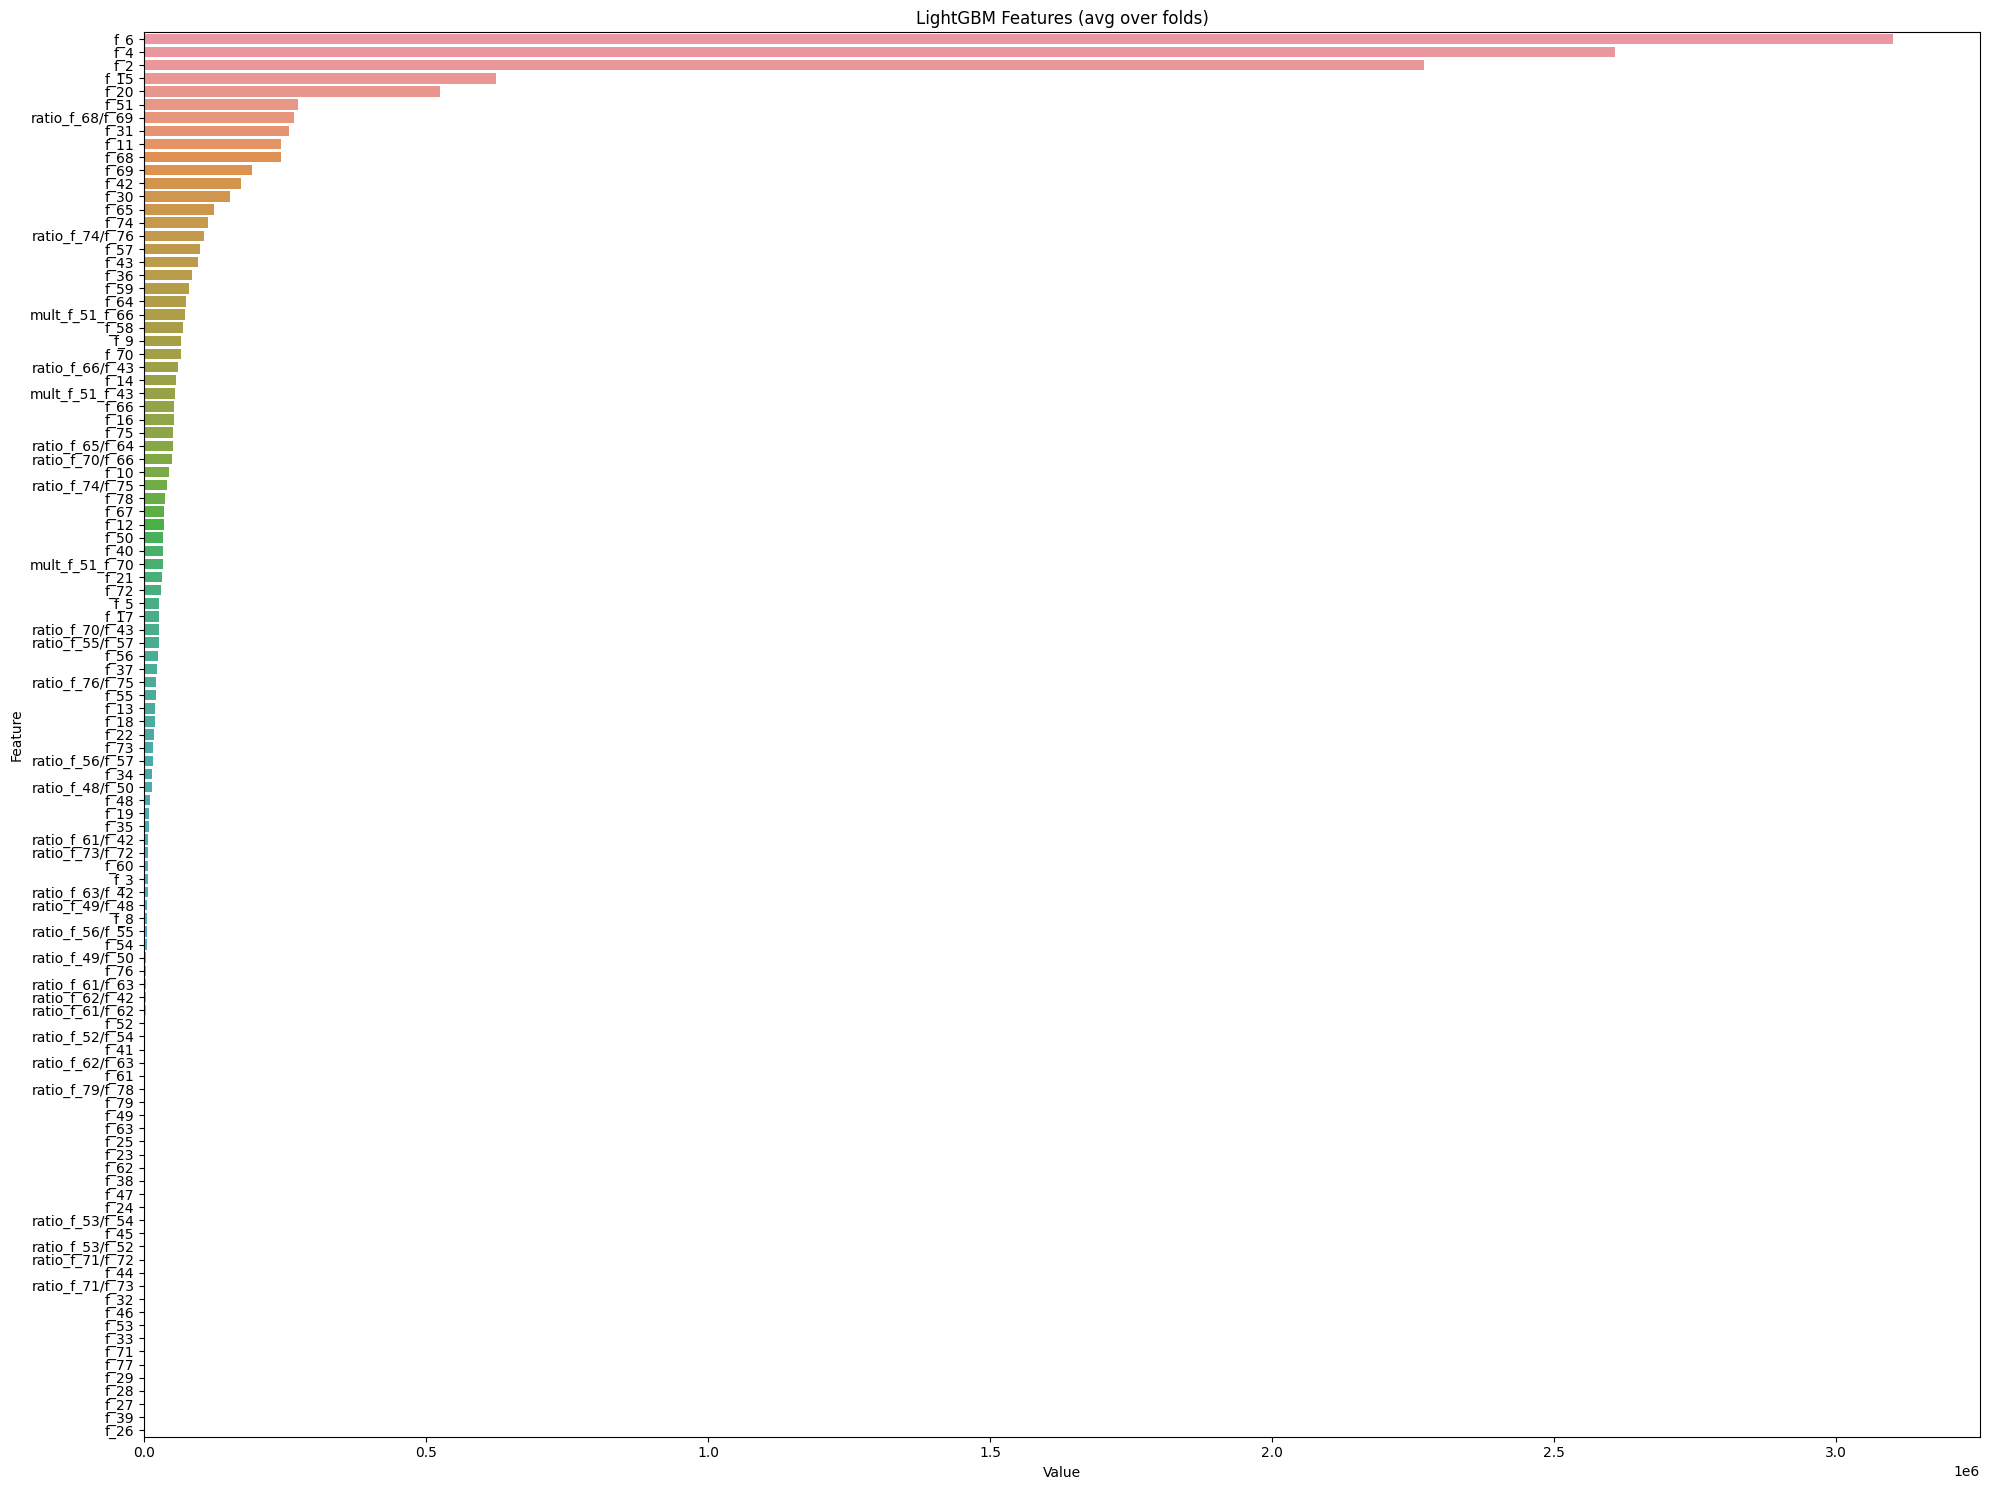

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='gain'),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [ ]:
feature_imp

,Value,Feature
0,0.000000e+00,f_26
1,0.000000e+00,f_27
2,0.000000e+00,f_28
3,0.000000e+00,f_29
4,0.000000e+00,f_39
5,5.441360e+01,f_77
6,7.127230e+01,f_71
7,9.417880e+01,f_33
8,1.089263e+02,f_53
9,1.243325e+02,f_46


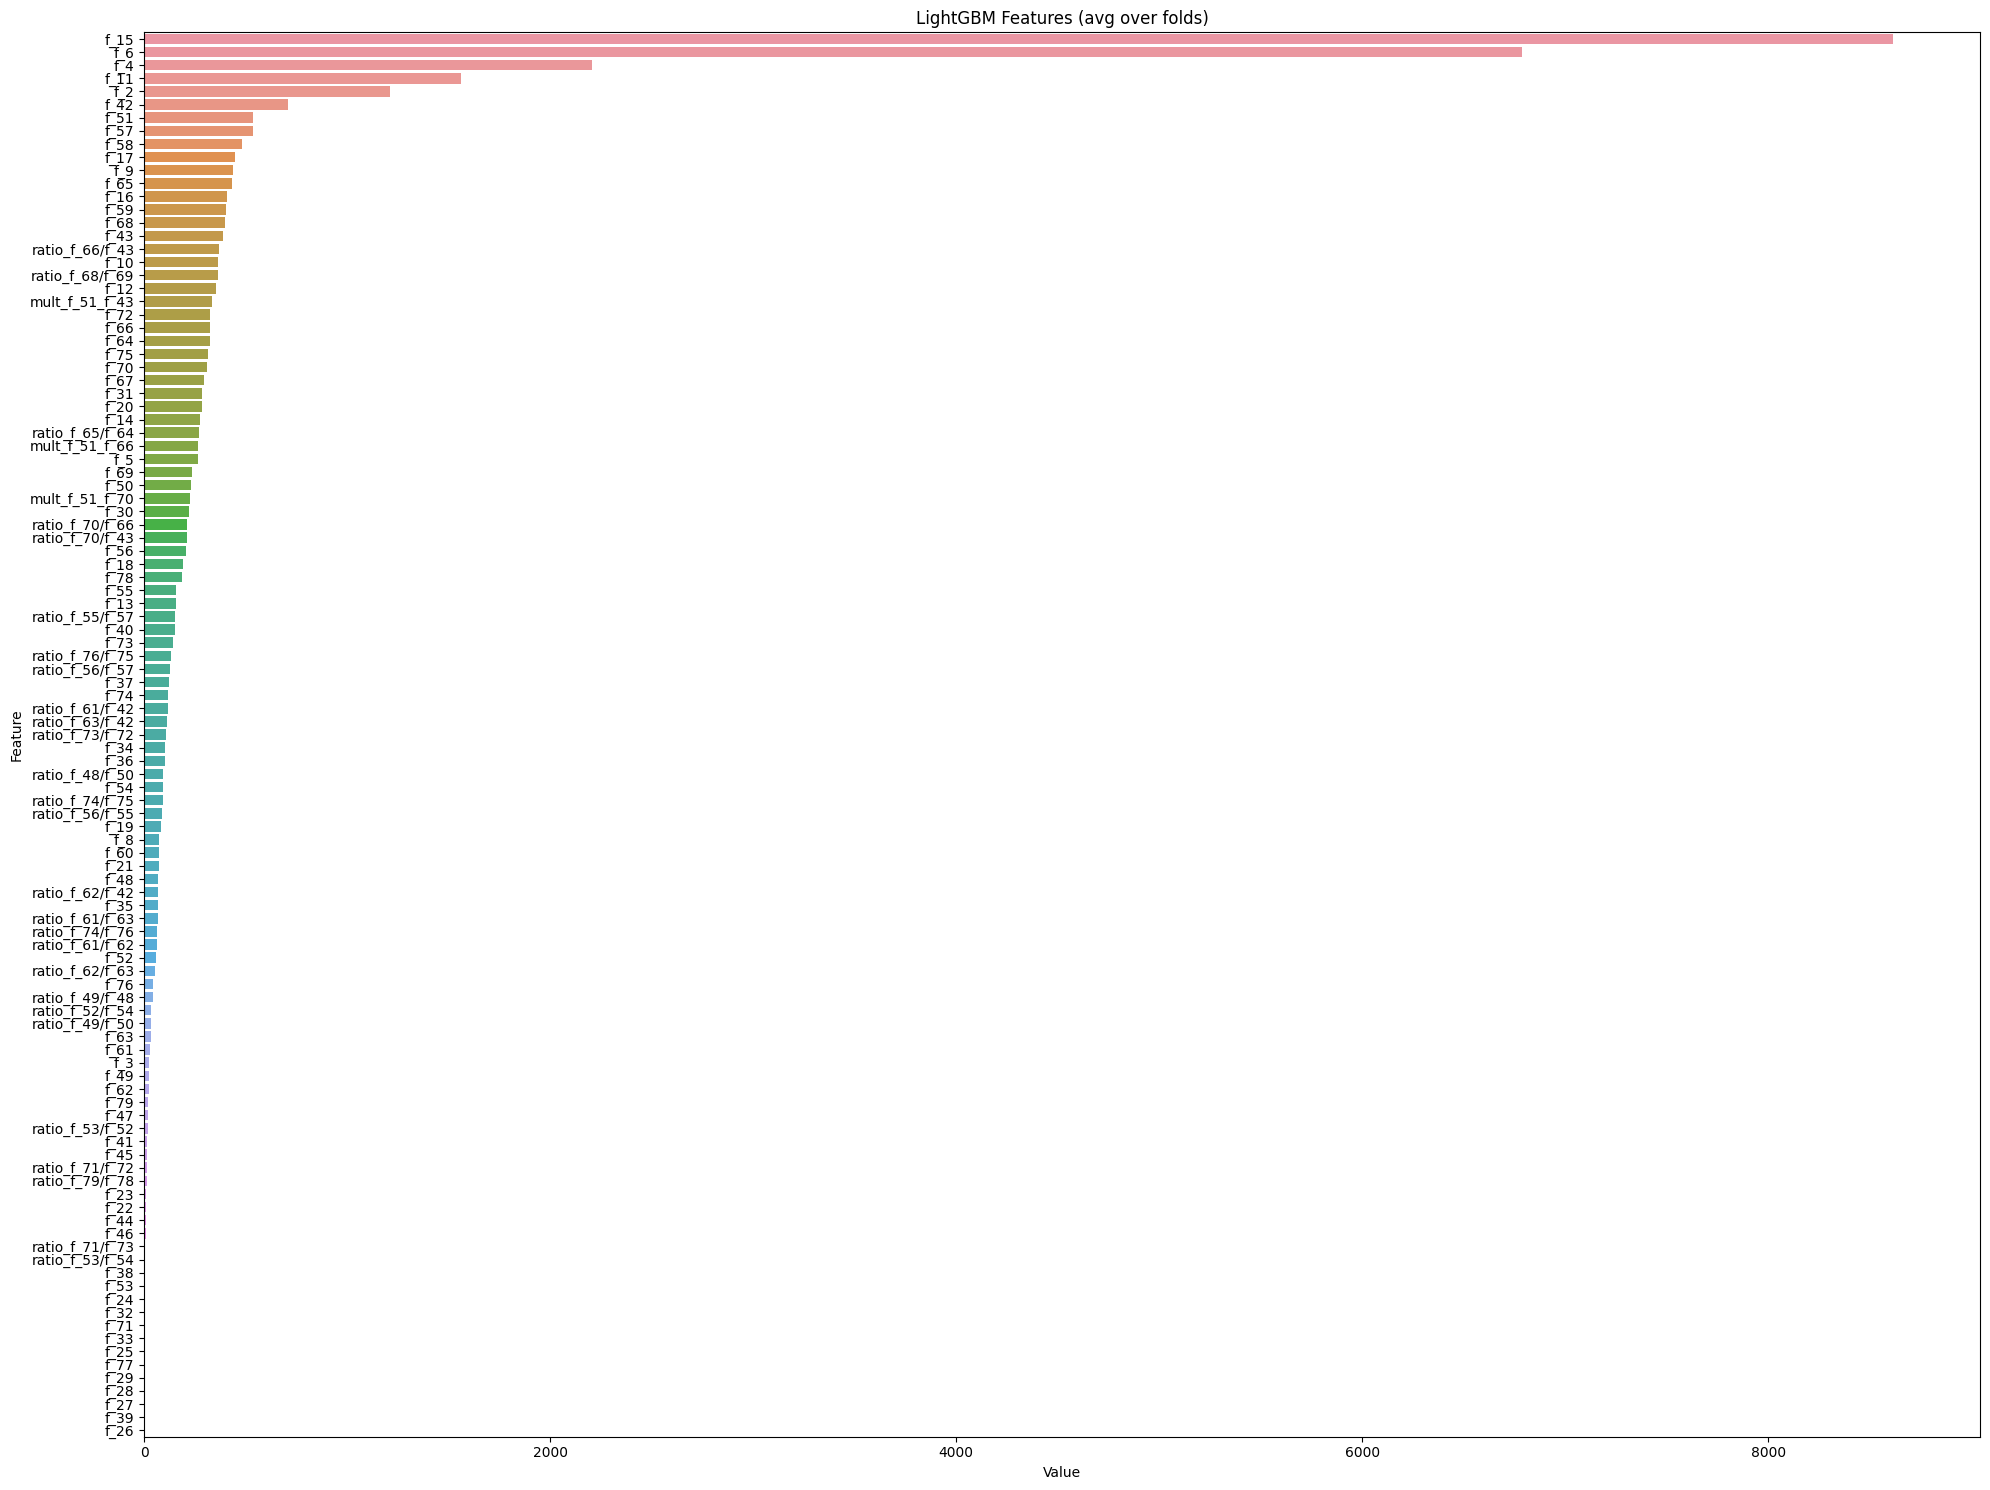

In [ ]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(importance_type='split'),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [ ]:
feature_imp

,Value,Feature
0,0,f_26
1,0,f_27
2,0,f_28
3,0,f_29
4,0,f_39
5,1,f_25
6,1,f_77
7,3,f_33
8,3,f_71
9,4,f_32


# Load and Submit

In [ ]:
test_id = np.load(f'{base_path}/RecSys2023/models/test_id.npy')
is_clicked = np.load(f'{base_path}/RecSys2023/models/is_clicked.npy')
is_installed = np.load(f'{base_path}/RecSys2023/models/is_installed.npy')

In [ ]:
print(test_id)
print(is_clicked)
print(is_installed)

[64505 64506 64507 ... 16242 16243 16244]
[0.25577705 0.09275746 0.09533253 ... 0.16979251 0.6662101  0.99933473]
[0.11579615 0.26489854 0.04076502 ... 0.03627285 0.1016192  0.04737712]


In [ ]:
# used for calibration
pos_sum = sum(is_installed)
pos_sum

21841.7119826635

In [ ]:
ENSEMBLE_FLAG = False
if ENSEMBLE_FLAG:
    en_res= np.zeros(len(test_id))
    #w = [0.25, 0.25, 0.25, 0.25]
    #w = [0.20, 0.30, 0.25, 0.25]
    #w = [0.20, 0.30, 0.20, 0.30]
    w=[0.20,0.20,0.25,0.35]
    for i in range(4):
        print(i)
        en_res += test_pred_period_list[i] * w[i]
    print(en_res)
    is_installed = en_res

In [ ]:
# day by day mean correction
CALIB_FLAG = False
if CALIB_FLAG:
    #ref=21688 old
    ref = 21827 #latest
    r = ref / pos_sum
    #r = 0.90
    print('calibration ratio:', r)
    #is_installed = is_installed * r
    is_installed = np.clip(is_installed, a_min=0.01, a_max=1)
    corrected = is_installed * r
    corrected = np.clip(corrected, a_min=0, a_max=1)

In [ ]:
data = np.column_stack((test_id, is_clicked, is_installed))
#data = np.column_stack((test_id, is_clicked, corrected))
sub = pd.DataFrame(data, columns=['row_id', 'is_clicked', 'is_installed'])
sub['row_id'] = sub['row_id'].astype(int)

In [ ]:
sub

,row_id,is_clicked,is_installed
0,64505,0.255777,0.115796
1,64506,0.092757,0.264899
2,64507,0.095333,0.040765
3,64508,0.190511,0.288391
4,64509,0.528456,0.058684
...,...,...,...
160968,16240,0.517120,0.227530
160969,16241,0.036342,0.003906
160970,16242,0.169793,0.036273
160971,16243,0.666210,0.101619


In [ ]:
#sub.to_csv(f'{base_path}/RecSys2023/output.csv', sep='\t', index=False, header=False)
sub.to_csv(f'{base_path}/RecSys2023/output.csv', sep='\t', index=False)

In [ ]:
# rule準拠でやり直し、std feature削ってまずは普通に学習
# [247]	training's binary_logloss: 0.22851	valid_1's binary_logloss: 0.34896, LB=6.537031 ここからスタート
# all, itr=200 pos_num=25706 	LB=6.304076
# weight=0.14を追加
# [255]	training's binary_logloss: 0.201511	valid_1's binary_logloss: 0.35281,
# pos rate = 0.14 (trainの11days meanとだいたい同じくらい), trainはposの割合減ってどういうわけかlossが減ったが、validのほうはover fit気味？ posnum=20791, LB=6.517452
# all itr=200 6.267492, LBに関しては悪くない
# pos rate = 0.15
# [328]	training's binary_logloss: 0.204819	valid_1's binary_logloss: 0.350062 LB = 6.543166 うーん
# all itr=200 6.235743, スコアだけ見ると良さそう
# pos rate = 0.145
# [324]	training's binary_logloss: 0.201299	valid_1's binary_logloss: 0.351534 LB = 6.52452
# all itr = 200 LB=6.262601

# TODO daybydayでstacking LR, pos rate最適な値探す+featureどれくらい工夫できるか調べる

